# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [47]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [49]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.363286
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 
Our normalized scores at the start are 0.1 for almost all of them.Our loss function is -log(normalized true score) which is - log(0.1). The reason that all of scores are very close to 0.1 is : We choose our weights accordingly. Our weights at the start are very low values and they also have mean 0 and standart deviation 1.


In [50]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.366163 analytic: -0.366163, relative error: 3.978820e-08
numerical: -1.529957 analytic: -1.529957, relative error: 3.499439e-08
numerical: -0.947756 analytic: -0.947756, relative error: 3.744848e-08
numerical: 1.086547 analytic: 1.086547, relative error: 7.501149e-08
numerical: -0.281356 analytic: -0.281356, relative error: 8.769525e-08
numerical: -3.576013 analytic: -3.576013, relative error: 1.294752e-09
numerical: -0.083194 analytic: -0.083194, relative error: 1.587028e-07
numerical: -0.664723 analytic: -0.664723, relative error: 6.423727e-08
numerical: 0.314079 analytic: 0.314079, relative error: 5.439363e-08
numerical: -3.945558 analytic: -3.945558, relative error: 2.144290e-10
numerical: 1.592014 analytic: 1.592014, relative error: 1.119172e-08
numerical: -1.244242 analytic: -1.244242, relative error: 6.257941e-08
numerical: -1.652086 analytic: -1.652086, relative error: 4.291413e-08
numerical: 0.139152 analytic: 0.139152, relative error: 2.138358e-07
numerical: 0.1

In [51]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.363286e+00 computed in 0.050001s
vectorized loss: 2.363286e+00 computed in 0.002009s
Loss difference: 0.000000
Gradient difference: 0.000000


In [52]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [0.5e-7,1e-7,2e-7,3e-7,5e-7,1e-8,5e-5,1e-6,2e-6,4e-6,8e-6]
regularization_strengths = [5e3,2e3,1e3,1e4,2e4,5e4,1e5,2e5]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for learning_rt in learning_rates:
    for reg_str in regularization_strengths:
            softmax = Softmax()
            loss_hist = softmax.train(X_train, y_train, learning_rate=learning_rt, reg=reg_str,
                      num_iters=1500, verbose=True)
            y_train_pred = softmax.predict(X_train)
            training_accuracy = np.mean(y_train == y_train_pred)
            y_val_pred = softmax.predict(X_val)
            validation_accuracy = np.mean(y_val == y_val_pred)
            results[(learning_rt,reg_str)] = (training_accuracy,validation_accuracy)
            if(validation_accuracy>best_val):
                best_val = validation_accuracy
                best_softmax = softmax

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 159.574085
iteration 100 / 1500: loss 143.533618
iteration 200 / 1500: loss 129.908926
iteration 300 / 1500: loss 117.300106
iteration 400 / 1500: loss 106.292249
iteration 500 / 1500: loss 96.339053
iteration 600 / 1500: loss 87.018164
iteration 700 / 1500: loss 78.798316
iteration 800 / 1500: loss 71.327721
iteration 900 / 1500: loss 64.640742
iteration 1000 / 1500: loss 58.749535
iteration 1100 / 1500: loss 53.197294
iteration 1200 / 1500: loss 48.219039
iteration 1300 / 1500: loss 43.761329
iteration 1400 / 1500: loss 39.822925
iteration 0 / 1500: loss 67.883305
iteration 100 / 1500: loss 64.166615
iteration 200 / 1500: loss 61.217977
iteration 300 / 1500: loss 58.963881
iteration 400 / 1500: loss 56.488278
iteration 500 / 1500: loss 53.994368
iteration 600 / 1500: loss 51.693824
iteration 700 / 1500: loss 49.396737
iteration 800 / 1500: loss 47.700129
iteration 900 / 1500: loss 46.127869
iteration 1000 / 1500: loss 44.052936
iteration 1100 / 1500: loss 42.

iteration 1200 / 1500: loss 2.229177
iteration 1300 / 1500: loss 2.205414
iteration 1400 / 1500: loss 2.219516
iteration 0 / 1500: loss 6132.885745
iteration 100 / 1500: loss 3.982132
iteration 200 / 1500: loss 2.228975
iteration 300 / 1500: loss 2.226924
iteration 400 / 1500: loss 2.260043
iteration 500 / 1500: loss 2.229704
iteration 600 / 1500: loss 2.213731
iteration 700 / 1500: loss 2.216932
iteration 800 / 1500: loss 2.255077
iteration 900 / 1500: loss 2.258606
iteration 1000 / 1500: loss 2.229542
iteration 1100 / 1500: loss 2.228376
iteration 1200 / 1500: loss 2.251559
iteration 1300 / 1500: loss 2.241277
iteration 1400 / 1500: loss 2.224692
iteration 0 / 1500: loss 159.398424
iteration 100 / 1500: loss 105.588107
iteration 200 / 1500: loss 70.873198
iteration 300 / 1500: loss 48.038622
iteration 400 / 1500: loss 32.653659
iteration 500 / 1500: loss 22.415059
iteration 600 / 1500: loss 15.711512
iteration 700 / 1500: loss 11.192276
iteration 800 / 1500: loss 8.094943
iteration 9

iteration 1100 / 1500: loss 2.158882
iteration 1200 / 1500: loss 2.135517
iteration 1300 / 1500: loss 2.181003
iteration 1400 / 1500: loss 2.185853
iteration 0 / 1500: loss 3038.483391
iteration 100 / 1500: loss 2.193832
iteration 200 / 1500: loss 2.217150
iteration 300 / 1500: loss 2.220498
iteration 400 / 1500: loss 2.174525
iteration 500 / 1500: loss 2.175022
iteration 600 / 1500: loss 2.210216
iteration 700 / 1500: loss 2.175594
iteration 800 / 1500: loss 2.217967
iteration 900 / 1500: loss 2.231394
iteration 1000 / 1500: loss 2.222154
iteration 1100 / 1500: loss 2.219990
iteration 1200 / 1500: loss 2.157599
iteration 1300 / 1500: loss 2.166727
iteration 1400 / 1500: loss 2.167244
iteration 0 / 1500: loss 6161.719263
iteration 100 / 1500: loss 2.238394
iteration 200 / 1500: loss 2.244393
iteration 300 / 1500: loss 2.242443
iteration 400 / 1500: loss 2.230157
iteration 500 / 1500: loss 2.217640
iteration 600 / 1500: loss 2.215349
iteration 700 / 1500: loss 2.252094
iteration 800 / 1

iteration 900 / 1500: loss 303.988923
iteration 1000 / 1500: loss 280.628304
iteration 1100 / 1500: loss 259.055158
iteration 1200 / 1500: loss 239.214147
iteration 1300 / 1500: loss 220.966538
iteration 1400 / 1500: loss 204.168242
iteration 0 / 1500: loss 1548.903629
iteration 100 / 1500: loss 1268.262212
iteration 200 / 1500: loss 1037.844892
iteration 300 / 1500: loss 849.662254
iteration 400 / 1500: loss 695.923334
iteration 500 / 1500: loss 569.894218
iteration 600 / 1500: loss 466.781565
iteration 700 / 1500: loss 382.353989
iteration 800 / 1500: loss 313.061968
iteration 900 / 1500: loss 256.601418
iteration 1000 / 1500: loss 210.486024
iteration 1100 / 1500: loss 172.669189
iteration 1200 / 1500: loss 141.593571
iteration 1300 / 1500: loss 116.267117
iteration 1400 / 1500: loss 95.561146
iteration 0 / 1500: loss 3094.314800
iteration 100 / 1500: loss 2073.680933
iteration 200 / 1500: loss 1389.471018
iteration 300 / 1500: loss 931.408268
iteration 400 / 1500: loss 624.484410
i

iteration 1400 / 1500: loss 2.019295
iteration 0 / 1500: loss 629.530415
iteration 100 / 1500: loss 2.170018
iteration 200 / 1500: loss 2.017793
iteration 300 / 1500: loss 2.062930
iteration 400 / 1500: loss 2.052564
iteration 500 / 1500: loss 2.043022
iteration 600 / 1500: loss 2.137267
iteration 700 / 1500: loss 2.114947
iteration 800 / 1500: loss 2.072504
iteration 900 / 1500: loss 2.101176
iteration 1000 / 1500: loss 2.077049
iteration 1100 / 1500: loss 2.058723
iteration 1200 / 1500: loss 2.075697
iteration 1300 / 1500: loss 2.077431
iteration 1400 / 1500: loss 2.055834
iteration 0 / 1500: loss 1532.968818
iteration 100 / 1500: loss 2.165115
iteration 200 / 1500: loss 2.178253
iteration 300 / 1500: loss 2.182346
iteration 400 / 1500: loss 2.124980
iteration 500 / 1500: loss 2.176743
iteration 600 / 1500: loss 2.165101
iteration 700 / 1500: loss 2.197223
iteration 800 / 1500: loss 2.131638
iteration 900 / 1500: loss 2.168259
iteration 1000 / 1500: loss 2.132790
iteration 1100 / 150

iteration 0 / 1500: loss 309.535334
iteration 100 / 1500: loss 2.167301
iteration 200 / 1500: loss 2.103081
iteration 300 / 1500: loss 2.060613
iteration 400 / 1500: loss 2.098941
iteration 500 / 1500: loss 2.020815
iteration 600 / 1500: loss 2.064990
iteration 700 / 1500: loss 2.245531
iteration 800 / 1500: loss 2.073792
iteration 900 / 1500: loss 2.134982
iteration 1000 / 1500: loss 2.105705
iteration 1100 / 1500: loss 2.021482
iteration 1200 / 1500: loss 2.102590
iteration 1300 / 1500: loss 2.030326
iteration 1400 / 1500: loss 2.035250
iteration 0 / 1500: loss 625.470276
iteration 100 / 1500: loss 2.143294
iteration 200 / 1500: loss 2.058926
iteration 300 / 1500: loss 2.166476
iteration 400 / 1500: loss 2.206883
iteration 500 / 1500: loss 2.164744
iteration 600 / 1500: loss 2.124886
iteration 700 / 1500: loss 2.130074
iteration 800 / 1500: loss 2.165789
iteration 900 / 1500: loss 2.241791
iteration 1000 / 1500: loss 2.130179
iteration 1100 / 1500: loss 2.196421
iteration 1200 / 1500

In [21]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.380000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$

True because softmax is probability based. Therefore it will never give 0 loss even for true image. This is not the case with SVM. SVM just wants correct image score to be higher than other scores + delta 



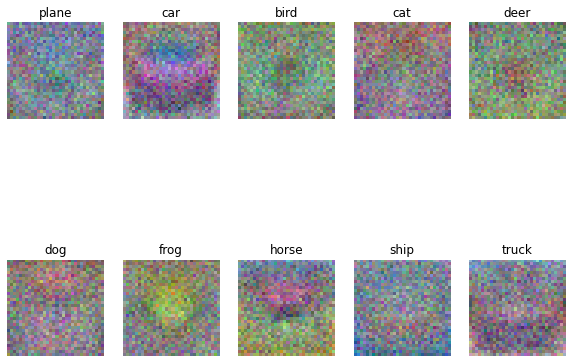

In [22]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])